# The model : Learning place cells, grid cells and invariances with excitatory and inhibitory plasticity 

Simon Nikolaus Weber, Henning Sprekeler

https://elifesciences.org/articles/34560

In this work, the authors propose a theoretical model for place cells and grid cells, as a combination of excitatory and inhibitory neurons. The main structure of these cells will depend on the relative smoothness between the tuning functions of the excitatory and inhibitory neurons, $r_i^{E}(x)$ and $r_i^{I}(x)$, where $x$ is the position. The output of cell is then

$$r^{out}(x(t)) = \left[ \sum^{Ne}_{i=1} w_i^{E}(t)r_i^{E}(x(t))-\sum^{Ni}_{j=1} w_j^{I}(t)r_j^{I}(x(t)) \right]_{+}$$

where $N_{e}$ and $N_{i}$ are the number of excitatory and inhibitory neurons, $w_{i}^{E}$ and $w_{j}^{E}$ are the weights, and taking, for example, the tuning curve being gaussian randombly centered around some position as $$r_i^P(x)=\alpha_p exp\big({-\frac{(x-\mu_i)^2}{2\sigma_p^2}}\big)$$

The plasticity rules for each of the weights is implemented as

$$\Delta w^{E}= \eta_E r^{E}(x)r^{out}(x)$$

and

$$\Delta w^{I} = \eta_{I}r^{I}(x)(r^{out}(x)-\rho_{0})$$.

These are the basic equations used in this model. The position is sampled either from a random distribution or following a recorded animal trajectory. Here we show our implementation of this model running it in some scenarios to generate grid cells.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Simple2D, Wernle2018, MergingRoom
from neuralplayground.agents import Weber2018, RandomAgent, LevyFlightAgent
from neuralplayground.experiments import Wernle2018Data

In [2]:
# Parameters for a square environment
room_width = [-10,10]
room_depth = [-10,10]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5

# Init environment
envsimple = Simple2D(arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

/Users/clementine/miniconda3/envs/NPG/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Here we pick adequate parameters to generate grid cells in this environment. Note that the exploration are just big random step within a squared box. For more details, please refer to our class documentation [Weber2018](https://github.com/ClementineDomine/NeuralPlayground/blob/main/neuralplayground/agents/weber_2018.py), or in the [original publication](https://elifesciences.org/articles/34560) of the model.

In [3]:
exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
roh = 1
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=roh,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)


100%|█████████████████████████████████████████████████████████████████████████████| 4900/4900 [00:02<00:00, 2250.18it/s]


This function shows the tuning curves for one random excitatory neuron, one random inhibitory neuron, and the rates for the output neuron.

array([<Axes: title={'center': 'Exc rates'}, xlabel='width', ylabel='depth'>,
       <Axes: title={'center': 'Inh rates'}, xlabel='width', ylabel='depth'>,
       <Axes: title={'center': 'Out rate'}, xlabel='width', ylabel='depth'>],
      dtype=object)

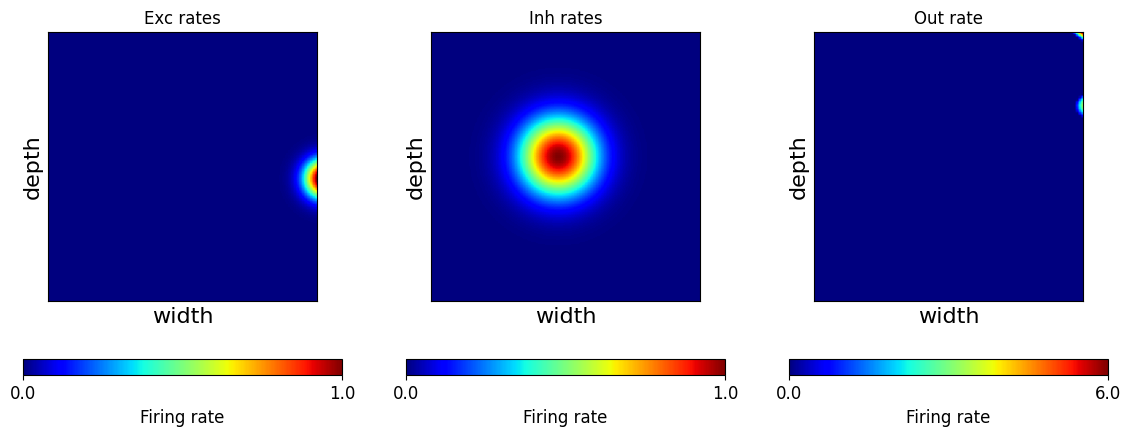

In [4]:
agent.plot_rates()

Now, we run the training of this model. In this case, the agent explores a 2D room with a brownian motion and big steps, to roughly sample uniformly accros the environment and facilitate the convergence in this demo. To get nice grid, we suggest a number of steps of 400000, but that might around 30 minutes depending on the machine you are running this. Reducing the number of iterations will generate a less nice grid pattern.

  0%|          | 0/400 [00:00<?, ?it/s]

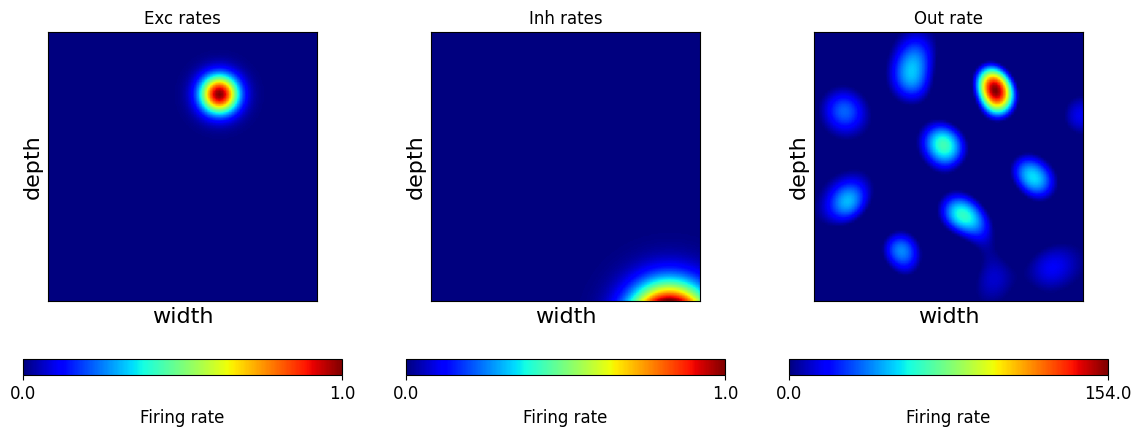

In [6]:
plot_every = 1000
total_iters = 0
n_steps = 400
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action, the first to numbers in the observation are the xy position of the agent
    obs = obs[:2]
    action = agent.act(obs)
    # rate = agent.update()
    agent.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action, normalize_step=True)
    total_iters += 1
    if i % plot_every == 0:
        agent.plot_rates()

# Use the line below to save the agent and use it later        
# agent.save_agent("post_merge.agent")

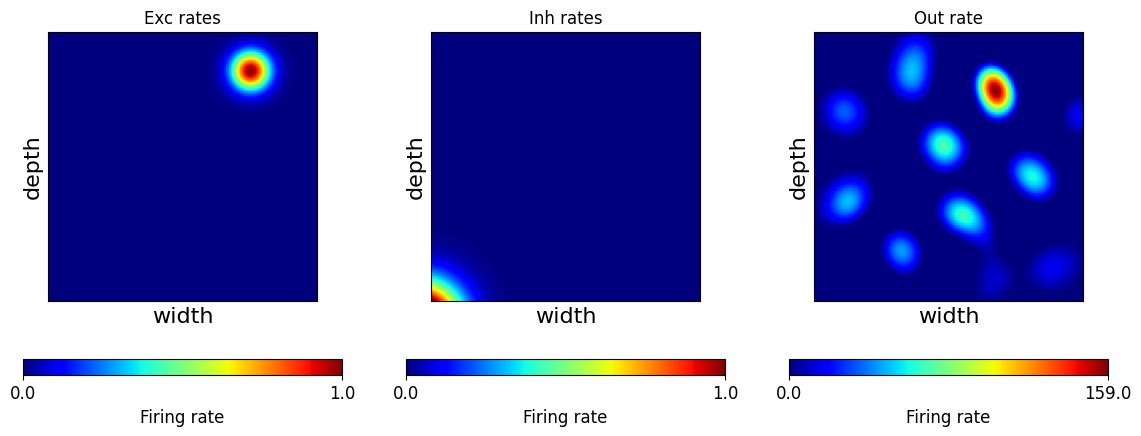

In [7]:
# Plotting rates and save it on a PDF
agent.plot_rates()
plt.savefig("nice_sargolini_grids.pdf", bbox_inches="tight")

Nex plot is the movement of the agent in the 2D environment. For the parameters used in this notebook it is pretty rough, but we found it helps for convergence in this particular example. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


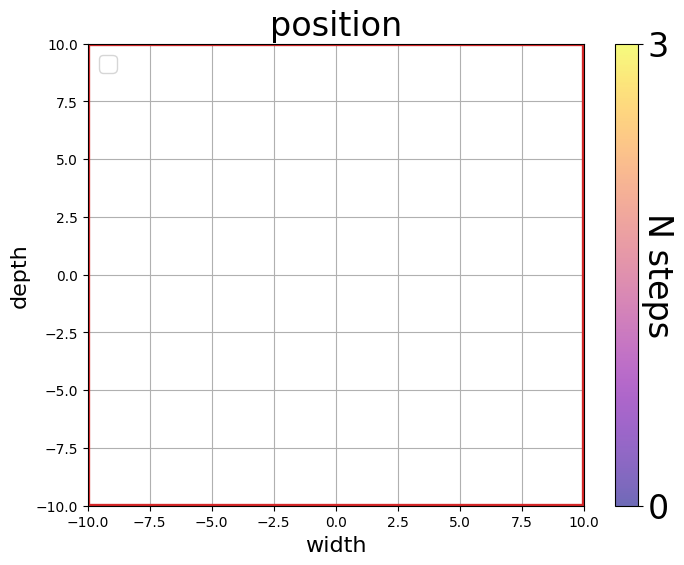

In [8]:
ax = envsimple.plot_trajectory(plot_every=100)
fontsize = 16
ax.grid()
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()

# Comparison with the mergint room experiment, Wernle et al. 2018

Here we run a simulation that resembles the experimental setting of [Wernle et al. 2018](https://www.nature.com/articles/s41593-017-0036-6). This comparison is also done in their paper. We are simply showing it as an example of a comparison between results from a theoretical model and real data, which in principle can be done using other theoretical models, other arenas and experimental data.

First we initialize the model using some of the parameters described in [original publication](https://elifesciences.org/articles/34560)

100%|█████████████████████████████████████████████████████████████████████████████| 9800/9800 [00:04<00:00, 2206.96it/s]


array([<Axes: title={'center': 'Exc rates'}, xlabel='width', ylabel='depth'>,
       <Axes: title={'center': 'Inh rates'}, xlabel='width', ylabel='depth'>,
       <Axes: title={'center': 'Out rate'}, xlabel='width', ylabel='depth'>],
      dtype=object)

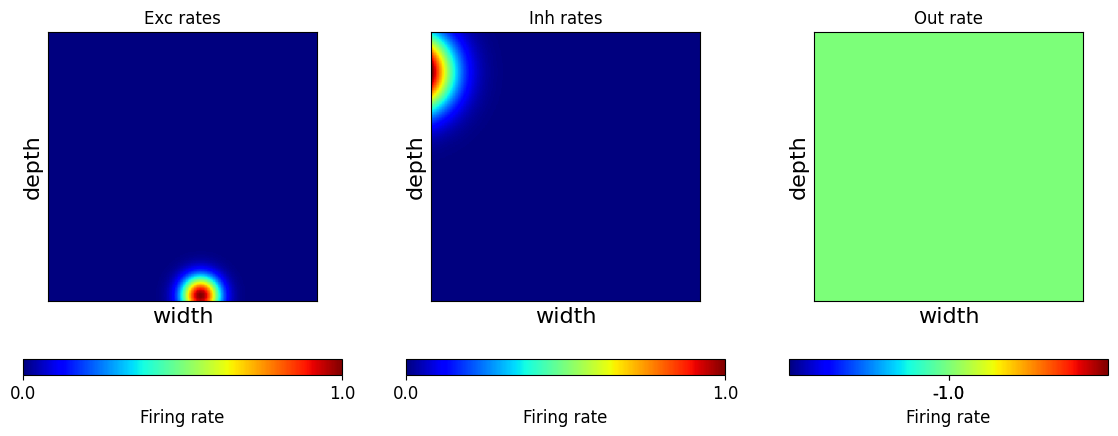

In [9]:
exc_eta = 1.3e-4
inh_eta = 5.3e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 2*4900
Ni = 2*1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.51
agent_step_size = 1.0
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

Here, we initialize the environment. In the original experiment, the animal is allowed to explore one room (the one at the bottom in the following plots) for 2.5 hrs, then the animal is moved to the room at the top and allowed to explore for another 2.5 hrs, and finally the wall in between is removed, merging both rooms with the animal exploring it for 5 hrs. Here the main parameters that define the experiments are the ```switch_time```, which is the time in minutes where the agents is moved from one room to another and ```merging_time``` which tells us when the wall in between is changed. These parameters are used to estimate the number of total time steps running the simulation, and the environment itself will take care of the switching of the agent and removal of the wall based on these parameters.

Feel free to reduce the time of switch and merging, which gives less number of iterations as a results. To get nice results, run with these parameters and go for a cup of coffee (or two), as it is it will take around 30 minutes (depending on the machine you are using).

In [10]:
time_step_size = 0.2
merging_time = 270*2.0  # Time in minutes to remove 
switch_time = 270.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 270.0

n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
fontsize = 16

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)

print(n_steps)
print(int((merging_time*60)/time_step_size))
print(int((switch_time*60)/time_step_size))

324000.0
162000
81000


/Users/clementine/miniconda3/envs/NPG/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
obs, state = env.reset()

for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    agent.update()
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        # agent.save_agent("pre_switch.agent")
        # plot rates
        agent.plot_rates()
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.plot_rates()
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

# Use the line below to save the agent and use it later        
# agent.save_agent("post_merge.agent")

  0%|          | 0/324000 [00:00<?, ?it/s]

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

agent.plot_rates()
plt.savefig("post_merge.pdf", bbox_inches="tight")

Ideally, you should see how some of the bombs in the rate map from each room also merge after removing the wall in between. This can be observed in the original dataset, which is also available in our package! Here we plot some of the rate maps before and after merging the rooms.

In [ ]:
w_data = Wernle2018Data()

In [ ]:
recording_list = w_data.show_data(full_dataframe=False)

In [ ]:
rates = w_data.plot_merging_comparison(session_index=(100, 125, 126, 127))

Note that there are environments that resemble some of the experiments listed in the package, and already load the experimental data. For more details about these please check the notebook examples for the different [arenas availables](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/arena_examples/arena_examples.ipynb) and [experimental data](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/experimental_examples/experimental_data_examples.ipynb).